In [1]:
import os

imdb_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()

        if label_type == 'neg':
            labels.append(0)
        else:
            labels.append(1)

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200 # trains on 200 samples
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

Found 88582 unique tokens.
Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


下面加载 `glove` 数据库，其中的每一行为单词以及单词向量，所以下面代码只是简单地读取每一行，然后将单词与其向量读出，单词作为 `embedding_index` 的索引，向量则初始化为 `numpy` 的向量。

In [3]:
glove_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/glove.6B'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embedding_index))

Found 400000 word vectors


下一步是构造可以用于 `Embedding` 层的矩阵，矩阵的形状必须是 `(max_words, embedding_dim)`，其中第 `i` 个元素为对应单词的向量。注意，`index = 0` 是用作占位符，不代表任何单词。

In [4]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

下面定义模型，在 `Embedding` 层后加上一个 `Flatten` 层扁平化数据，然后用全连接层输出。

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

2023-10-02 23:11:23.583413: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-02 23:11:23.583480: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-02 23:11:23.583525: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-02 23:11:23.583600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-02 23:11:23.583657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1320065 (5.04 MB)
Trainable params: 1320065 (5.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


下面将上面初始化好的单词向量矩阵作为 `Embedding` 层的权重，然后将其冻结。因为作为一个预训练模型，在训练新数据的时候很容易会破坏原来的参数，所以还是得先将这个 `Embedding` 层冻结。

In [6]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [10]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('/Users/bifnudozhao/Projects/ai-playground/results/aclImdb_with_glove.h5')

Epoch 1/10


2023-10-02 23:16:43.059835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 4s 293ms/step - loss: 2.1538 - accuracy: 0.4950 - val_loss: 0.7789 - val_accuracy: 0.5577
Epoch 2/10
7/7 [==============================] - 1s 206ms/step - loss: 0.5361 - accuracy: 0.7150 - val_loss: 0.7666 - val_accuracy: 0.5512
Epoch 3/10
7/7 [==============================] - 1s 209ms/step - loss: 0.5131 - accuracy: 0.7250 - val_loss: 0.7654 - val_accuracy: 0.5577
Epoch 4/10
7/7 [==============================] - 1s 210ms/step - loss: 0.4761 - accuracy: 0.7500 - val_loss: 0.7611 - val_accuracy: 0.5576
Epoch 5/10
7/7 [==============================] - 1s 237ms/step - loss: 0.4491 - accuracy: 0.7550 - val_loss: 0.9182 - val_accuracy: 0.5324
Epoch 6/10
7/7 [==============================] - 1s 204ms/step - loss: 0.4785 - accuracy: 0.7800 - val_loss: 0.7539 - val_accuracy: 0.5594
Epoch 7/10
7/7 [==============================] - 1s 207ms/step - loss: 0.4170 - accuracy: 0.8300 - val_loss: 0.7795 - val_accuracy: 0.5640
Epoch 8/10
7/7 [===============

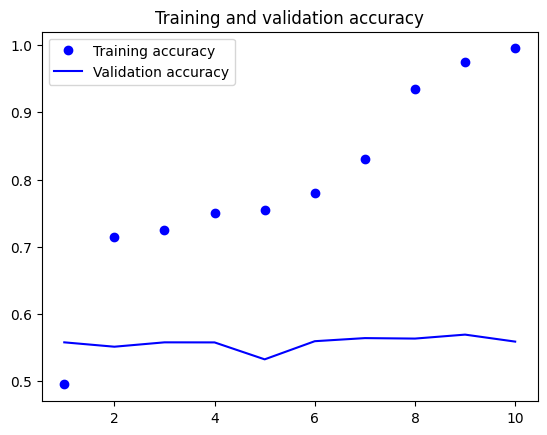

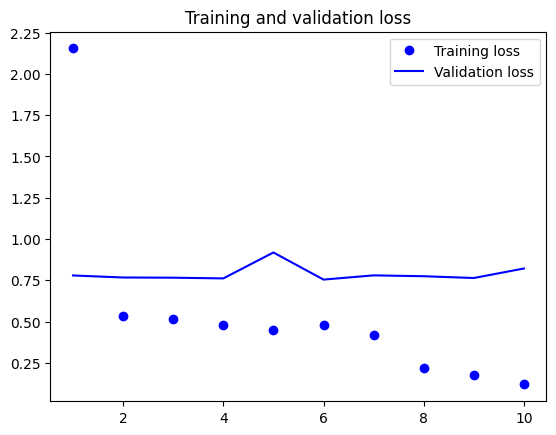

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()